In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

import pims
import trackpy as tp
# get video props > make function for that

# try alternative read in and video-readin
# images = pims.ImageSequence(f"{frames_filepaths}/*.jpg")
# vframes = pims.MoviePyReader(vid_filepath)  # only have movieby in python 3.10 env!

In [2]:
from piv_utils import get_trajectory_stats

# 1. Paths and Read-In

In [3]:
vid_path = "./data/videos/birdbath/vortex/"
vid_filename = "2024_0325_161529_030.MP4"  # 60 fps # "2024_0325_161426_028.MP4"  # 24fps #    
# 60fps might have to much flickering > increasing noise level for stationary pixels, try 24fps > DOESNT HELP
vid_filepath = f"{vid_path}{vid_filename}"
frames_filepaths = f"./data/images/{vid_filename.split('.')[0]}/"

img_seq_folder = f"{frames_filepaths}/*.jpg"
frames = pims.as_grey(pims.open(img_seq_folder))  # before only used the green channel! now things look different in the locate function
frames

(ImageSequence,) processed through proc_func. Original repr:
    <Frames>
    Source: /Users/mikehemberger/Documents/vscode/rotifer-locomotion/data/images/2024_0325_161529_030/*.jpg
    Length: 2420 frames
    Frame Shape: (1080, 1920, 3)
    Pixel Datatype: uint8

In [5]:
img_width = frames[0].shape[1]
img_height = frames[0].shape[0]

time = np.linspace(0, len(frames) / 60, len(frames))
tmax = len(frames)
tpoint2 = np.where(time >= 30)[0][0]  # from 25sec onwards
print("tpoints 2 frames=", tmax - tpoint2, tpoint2)

tpoints 2 frames= 620 1800


## Locate features for single frame

In [35]:
frames2 = frames[tpoint2:] - frames[frame_nr]# - frames[frame_nr-1]

/Users/mikehemberger/opt/miniconda3/lib/python3.9/site-packages/trackpy/find.py:109: UserWarning: Image is completely black.
  warnings.warn("Image is completely black.", UserWarning)


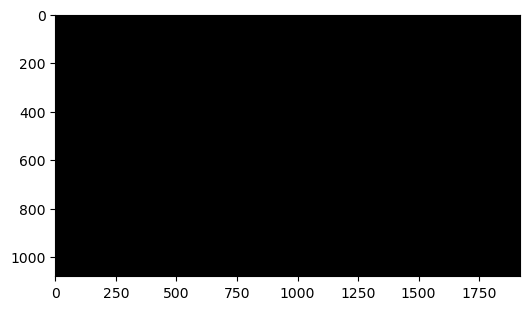

0


Empty DataFrame
Columns: [y, x, mass, size, ecc, signal, raw_mass]
Index: []

In [36]:
f = tp.locate(frames2[0], diameter, invert=True, threshold=threshold)

plt.figure(figsize=(6,6))
tp.annotate(f, frames2[0], plot_style={"markersize" : 10});
#tp.annotate(f, frames[frame_nr] - frames[frame_nr-1], plot_style={"markersize" : 10});
print(len(f))
f.head(5)

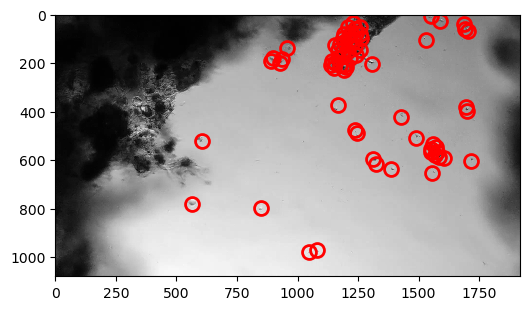

70


y            x         mass      size       ecc     signal  \
0   6.817708  1551.707986   880.793268  2.479499  0.443555  44.039663   
1  23.807146  1587.396244   667.629064  2.023680  0.238569  37.617212   
2  31.828772  1227.024238   391.157844  2.218340  0.344506  25.078142   
3  38.915735  1687.748695   820.238731  2.501454  0.375606  37.923043   
4  48.345269  1256.018600  1315.379113  2.959268  0.424321  53.214593   

    raw_mass        ep  frame  
0   739.7304  0.107665   1801  
1   268.1426  0.440021   1801  
2  -235.9284 -0.191347   1801  
3  1398.7230  0.052379   1801  
4  1541.6615  0.047130   1801

In [34]:
# 60fps
diameter = 13
threshold = 15
frame_nr = tpoint2

# Location of features
#f = tp.locate(frames[frame_nr], diameter, invert=True, threshold=threshold)
f = tp.locate(frames[frame_nr] - frames[frame_nr-1], diameter, invert=True, threshold=threshold)

plt.figure(figsize=(6,6))
tp.annotate(f, frames[frame_nr], plot_style={"markersize" : 10});
#tp.annotate(f, frames[frame_nr] - frames[frame_nr-1], plot_style={"markersize" : 10});
print(len(f))
f.head(5)

# 2. Batch Process frames

In [28]:
tp.quiet()
f = tp.batch(frames[tpoint2:], diameter, invert=True, threshold=threshold)
print(len(f))

53937


### Plot some of the parameters of detected particels

### filter frames based on coordinates

In [29]:
# f2 = f[(f["x"] > 500)]
# print(len(f), len(f2))
f2 = f

# 3. Link particles / frames to trajectories

In [30]:
tp.quiet()
max_displacement = 55  # in px
particle_memory = 3
t = tp.link(f2, max_displacement, memory=particle_memory, adaptive_stop=10, adaptive_step=.95)
t.head()

y            x         mass      size       ecc     signal  \
0       25.845258  1589.284526  1037.756035  3.096990  0.541189  46.275976   
35950  682.115438  1203.658554   376.122266  1.477932  0.053763  38.710776   
35951  695.332599  1794.093000  1068.731278  3.092354  0.266385  26.940607   
35952  701.475840   616.556723   249.004449  1.435958  0.145621  27.986845   
35953  753.375641  1664.325412   968.554068  2.765866  0.463023  41.064809   

        raw_mass        ep  frame  particle  
0       636.2019  0.130886   1799         0  
35950   844.3304  0.138840   1799         1  
35951  4830.7418  0.021663   1799         2  
35952   996.8589  0.115032   1799         3  
35953  1671.7217  0.065407   1799         4

# 4. Trajectories

## Filtering based on number of frames

In [31]:
lasts_num_frames = 30
t1 = tp.filter_stubs(t, lasts_num_frames)
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())
# t1.to_csv("./data/results/vortex/traj1.csv")

Before: 53937
After: 0


### Trajectory stats

# reject trajectories

In [17]:
stats, frames_present = get_trajectory_stats(t1)
ctraj = t1

# rejection conditions
reject_idx = (stats.x_std < 30) & (stats.y_std < 30) #& (stats.displacement_first_last < 70)
reject_prts = stats.particle[reject_idx].to_numpy()
reject_prts = np.append(reject_prts, [56, 81]) 
reject_traj_idx = []
for rprt in reject_prts:
    reject_traj_idx.append(np.where(ctraj["particle"] == rprt)[0])
reject_traj_idx = np.concatenate(reject_traj_idx)

tmp = ctraj.reset_index(drop=True)
traj_rejected = tmp.iloc[reject_traj_idx, :]
ctraj = tmp.drop(reject_traj_idx)
del tmp

particles = ctraj.particle.unique()
particles_rejected = traj_rejected.particle.unique()
print("number of particle trajectories:", len(particles))
print("number of rejected particle trajectories:", len(particles_rejected))
# further particels to reject 81, 56

number of particles = number of trajectories: 362
number of particle trajectories: 132
number of rejected particle trajectories: 230


## Visualize Trajectories

/Users/mikehemberger/opt/miniconda3/lib/python3.9/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]


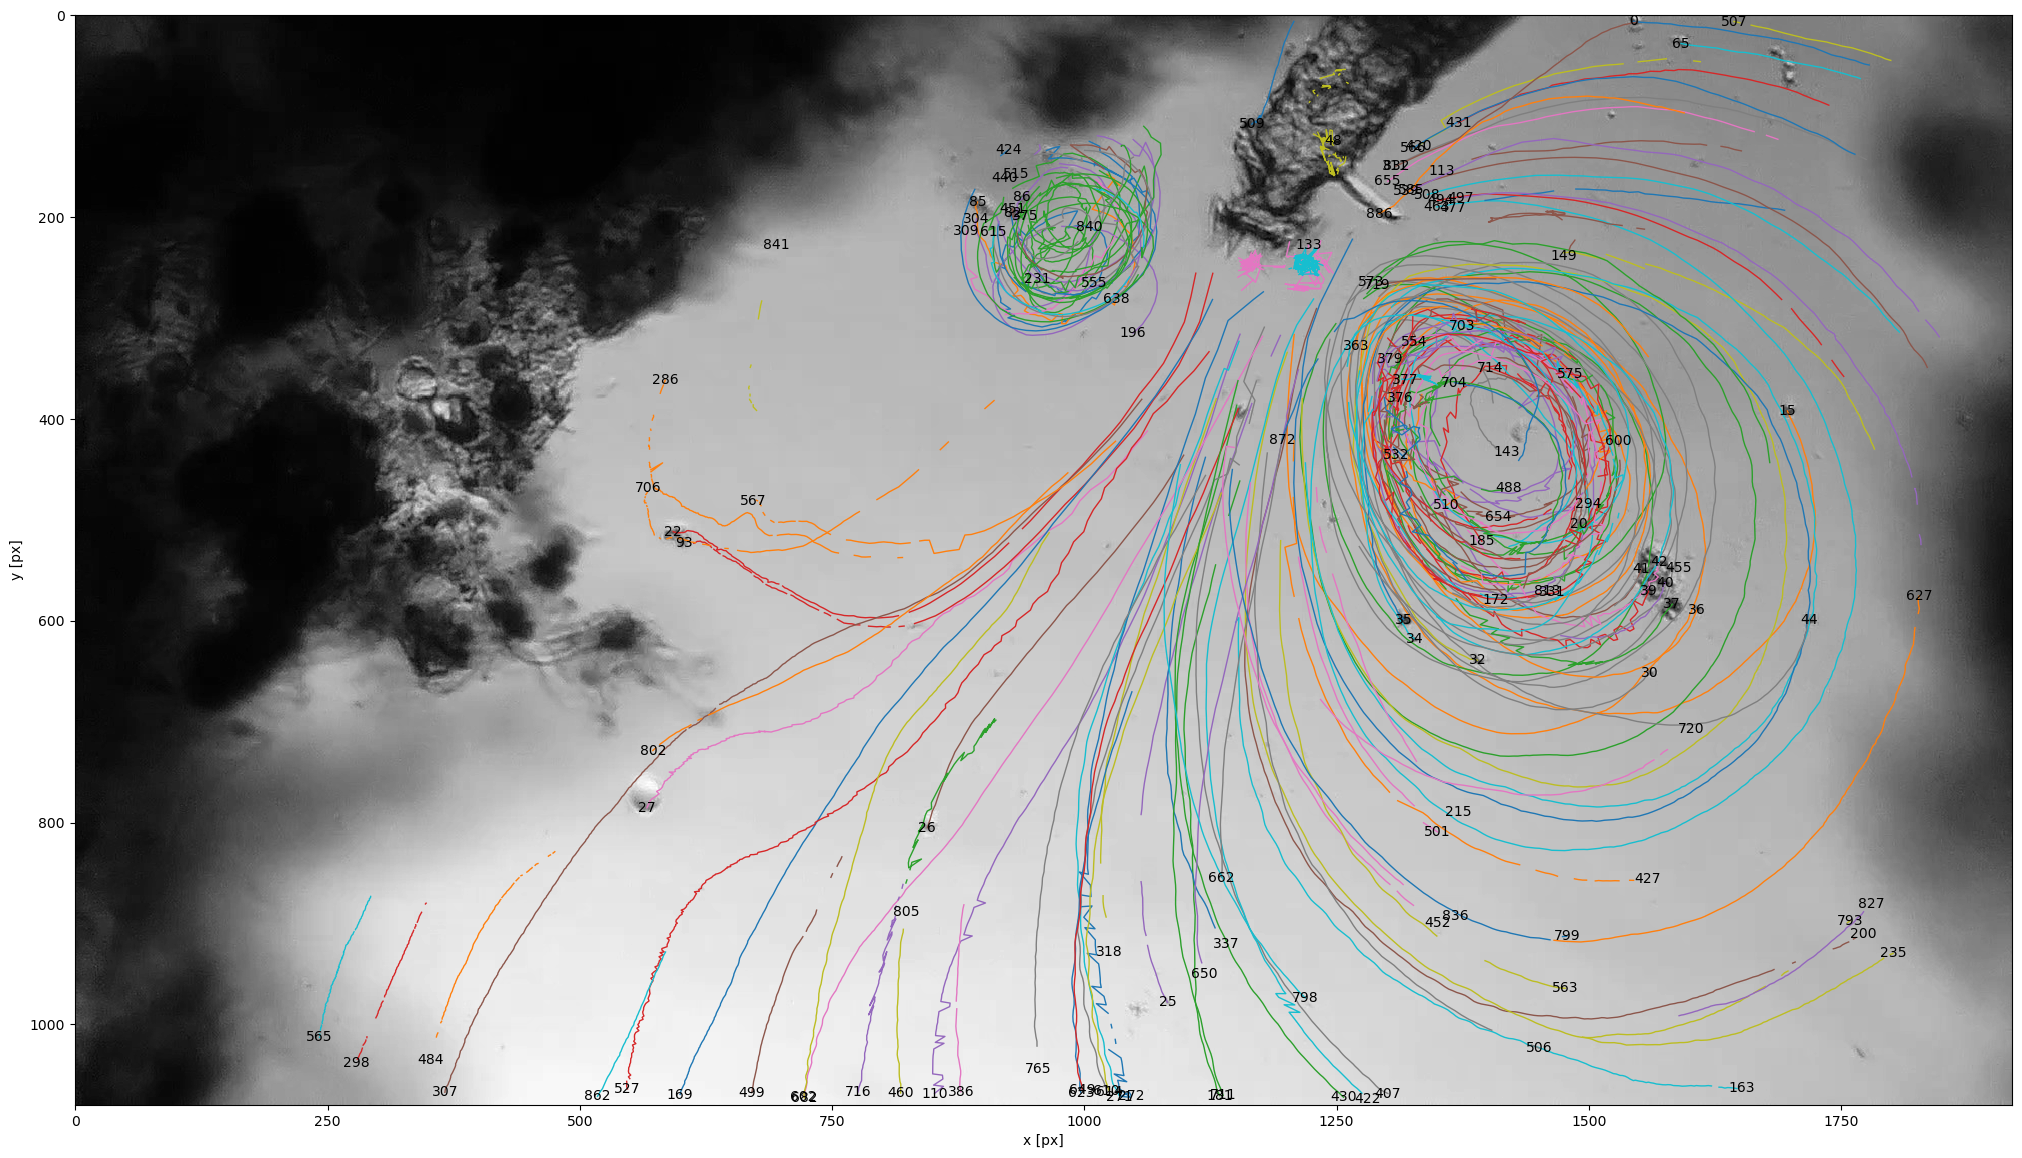

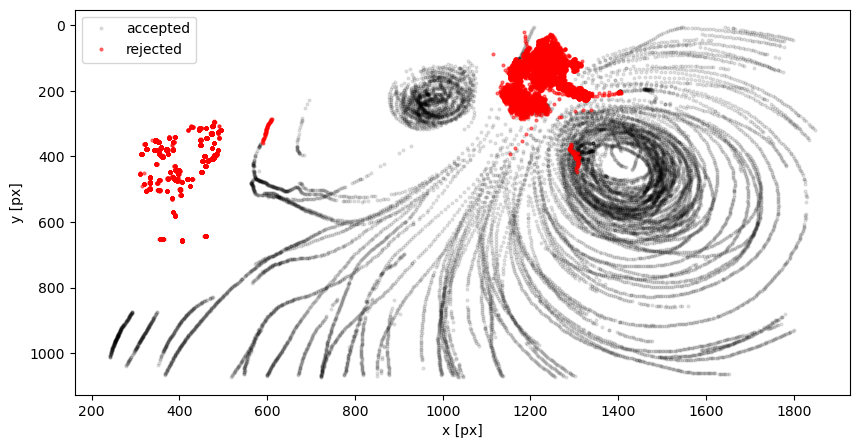

In [18]:
# This plots trajectories with associated particle number
fig, ax = plt.subplots(figsize=(25,25))
tp.plot_traj(ctraj, superimpose=frames[frame_nr], label=True, ax=ax);

frame_nr = tpoint2

fig, ax = plt.subplots(figsize=(10,5))
tp.scatter(ctraj, ax=ax, plot_style={"ms" : 2, "alpha" : .1, "color" : "k", "label" : "accepted"})
tp.scatter(traj_rejected, ax=ax, plot_style={"ms" : 2, "alpha" : .5, "color" : "r", "label" : "rejected"})
ax.legend()

## recalculate stats

In [19]:
stats, frames_present = get_trajectory_stats(ctraj)
stats.head(10)

number of particles = number of trajectories: 132


particle        x_avg       y_avg       x_std       y_std  travel_dist  \
0          0  1672.693972   24.324306   68.729291   13.248870   238.875871   
15        15  1471.956746  518.416848  132.968215  130.161986  4083.766026   
20        20  1456.584205  496.322593  120.484056  144.194918  4020.497313   
22        22   753.886725  531.065480  141.043940   64.942952   718.160349   
25        25  1084.741655  723.301768   33.291954  177.739687   686.135766   
26        26   942.169315  641.841168   77.579667  104.386743   501.955932   
27        27   718.444678  680.583841  127.466177   82.698444   726.762027   
30        30  1450.947273  497.699351  118.672491  138.573523  4322.851425   
32        32  1499.263821  557.778943  160.326898  166.256322  1870.943844   
34        34  1520.600542  568.227010  171.707993  174.800579  1864.108124   

                                       frames_present  first_frame  \
0   [1800, 1801, 1802, 1803, 1804, 1805, 1806, 180...         1800   
15  [1800, 1801, 1802, 1803, 1804, 1805, 1806, 180...         1800   
20  [1800, 1801, 1802, 1803, 1804, 1805, 1806, 180...         1800   
22  [1800, 1801, 1802, 1803, 1804, 1805, 1806, 180...         1800   
25  [1800, 1801, 1802, 1803, 1804, 1805, 1806, 180...         1800   
26  [1800, 1801, 1802, 1803, 1804, 1805, 1806, 180...         1800   
27  [1800, 1801, 1802, 1803, 1804, 1805, 1806, 180...         1800   
30  [1800, 1801, 1802, 1803, 1804, 1805, 1806, 180...         1800   
32  [1800, 1801, 1802, 1803, 1804, 1805, 1806, 180...         1800   
34  [1800, 1801, 1802, 1803, 1804, 1805, 1806, 180...         1800   

    last_frame  nframes    ep_mean  ep_median  displacement_first_last  
0         1841       42   1.043423   1.024501               237.664933  
15        2404      605   2.499845   1.243318               494.557767  
20        2419      616 -11.857817   1.257263               151.679820  
22        1938      136   0.410165  -3.970590               577.763442  
25        1879       69  -0.459043  -0.390789               670.116838  
26        1850       50   2.350545  -0.784905               497.791841  
27        1959      159  -5.550432  -1.894919               661.592714  
30        2419      619   5.970407  -0.962767               309.075202  
32        2068      269  -2.185217  -1.061615               311.979480  
34        2081      279   0.075074  -0.765074               245.326513

# Velocity field calculation

In [20]:
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

particles = ctraj.particle.unique()

df = pd.DataFrame()
for nth in particles:#is_continuous:  #list(set(ctraj.particle)):
    traj = ctraj.loc[ctraj["particle"] == nth]
    d = {
        "x" : traj.x.to_list(),
        "y" : traj.y.to_list(),
        "dx" : traj.x.diff().to_list(),
        "dy" : traj.y.diff().to_list()
    }
    # have to interpolate so that there are no jumps in velocity across frames
    df_loop = pd.DataFrame(d)
    df = pd.concat([df, df_loop[1:]])

df#_loop
# Generate some sample data (replace this with your actual data)

points = df[["x", "y"]].to_numpy()
print(points.shape)
velocities = df[["dx", "dy"]].to_numpy()

# # Define grid for velocity field
grid_x, grid_y = np.meshgrid(np.linspace(0, img_width, img_width), np.linspace(0, img_height, img_height))

# # Interpolate velocities onto grid
grid_u = griddata(points, velocities[:, 0], (grid_x, grid_y), method='linear')
grid_v = griddata(points, velocities[:, 1], (grid_x, grid_y), method='linear')


(16998, 2)


In [21]:
np.diff(grid_x[0,:2])
#np.diff(grid_y[:2,0])

array([1.0005211])

In [22]:
# import numpy as np

# def cartesian_to_polar(x, y):
#     r = np.sqrt(x**2 + y**2)
#     theta = np.arctan2(y, x)
#     return r, theta

# def radial_speed(x, y, vx, vy):
#     # Convert Cartesian coordinates to polar coordinates
#     r, theta = cartesian_to_polar(x, y)
#     # Calculate radial speed
#     v_radial = (x*vx + y*vy) / r    
#     return v_radial

# x = np.array([1, 2, 3])  # Example x coordinates
# y = np.array([4, 5, 6])  # Example y coordinates
# vx = np.array([0.1, 0.2, 0.3])  # Example x velocities
# vy = np.array([0.2, 0.3, 0.4])  # Example y velocities

# # Calculate radial speed for each particle
# v_radial = radial_speed(x, y, vx, vy)

# print("Radial speeds:", v_radial)

def vorticity_from_velocity(dx, dy, u, v):
    dudy = np.gradient(u, axis=0) / dy
    dvdx = np.gradient(v, axis=1) / dx
    return dvdx - dudy

dx = np.diff(grid_x[0, :])[0]
dy = np.diff(grid_y[:, 0])[0]

print(dy)
omega = vorticity_from_velocity(dx, dy, grid_u, grid_v)
omega
(~np.isnan(omega)).sum()

1.0009267840593141


1335906

In [23]:
np.nanmin(omega)
np.nanmax(omega)

19.361624306375735

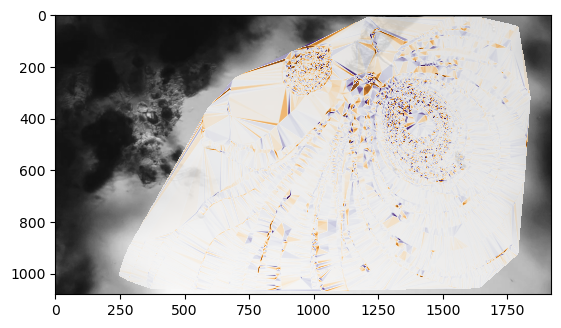

In [24]:
plt.figure()
plt.imshow(frames[frame_nr], cmap="gray", alpha=.95)
plt.imshow(omega, vmin=-3,vmax=3, cmap="PuOr", alpha=.8)
# could be a binning problem!!!


In [95]:
# def vorticity(Vx, Vy, x, y):
#     # Calculate partial derivatives
#     dVy_dx = np.gradient(Vy, x, axis=1)
#     dVx_dy = np.gradient(Vx, y, axis=0)
    
#     # Calculate vorticity
#     omega = dVy_dx - dVx_dy
    
#     return omega

# omega = vorticity(velocities[:,0], velocities[:,1], points[:,0], points[:,1])
# omega

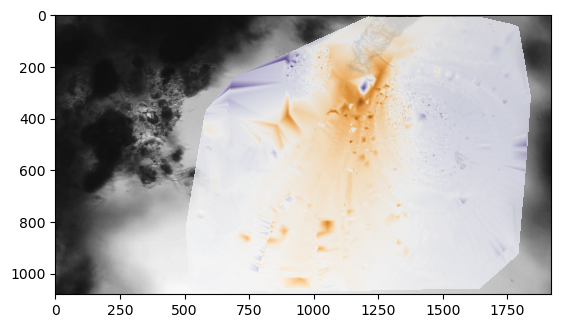

In [102]:
plt.figure()
plt.imshow(frames[frame_nr], cmap="gray", alpha=.95)
plt.imshow(grid_v, cmap="PuOr", alpha=.8)

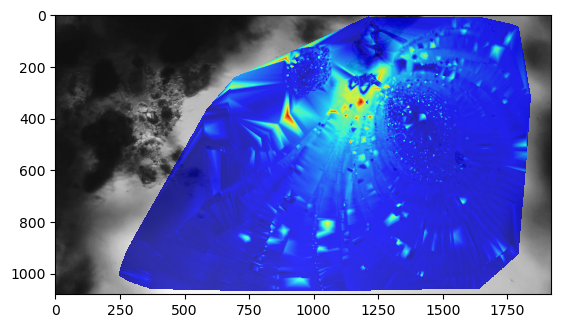

In [25]:
speed = np.sqrt(grid_v ** 2 + grid_u ** 2)
plt.figure()
plt.imshow(frames[frame_nr], cmap="gray", alpha=.95)
plt.imshow(speed, cmap="jet", alpha=.8)

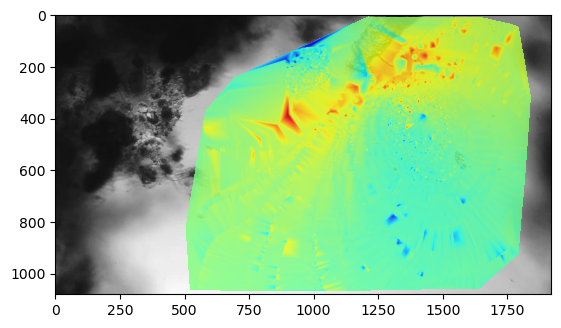

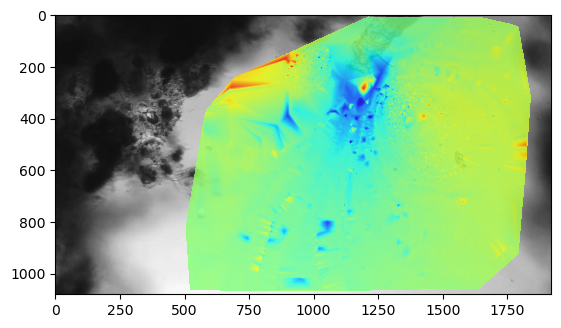

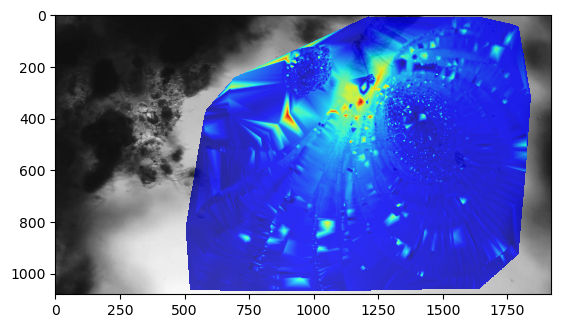

In [103]:
plt.figure()
plt.imshow(frames[frame_nr], cmap="gray", alpha=.95)
plt.imshow(grid_u, cmap="jet", alpha=.8)

plt.figure()
plt.imshow(frames[frame_nr], cmap="gray", alpha=.95)
plt.imshow(grid_v, cmap="jet", alpha=.8)

speed = np.sqrt(grid_v ** 2 + grid_u ** 2)
plt.figure()
plt.imshow(frames[frame_nr], cmap="gray", alpha=.95)
plt.imshow(speed, cmap="jet", alpha=.8)

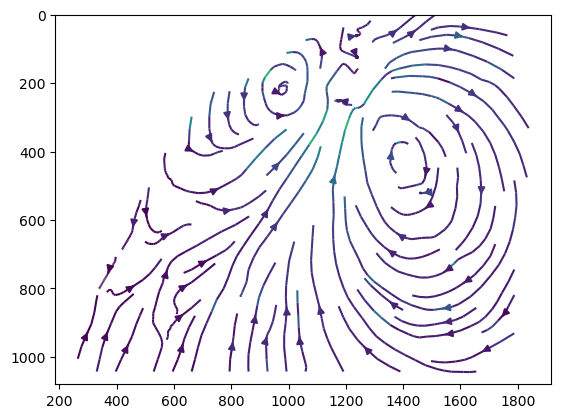

In [26]:
plt.figure()
plt.streamplot(grid_x, grid_y, grid_u, grid_v, color=speed) # , density=1broken_streamlines=False, linewidth=20*speed / speed.max()
plt.gca().invert_yaxis()

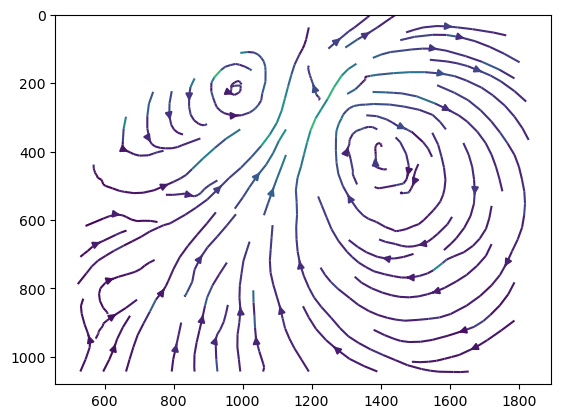

In [110]:
plt.figure()
plt.streamplot(grid_x, grid_y, grid_u, grid_v, color=speed) # , density=1broken_streamlines=False, linewidth=20*speed / speed.max()
plt.gca().invert_yaxis()

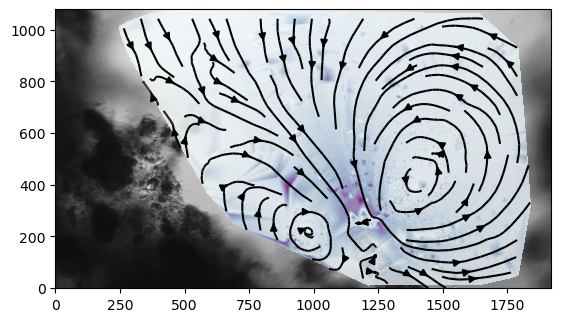

In [27]:
plt.figure()
plt.imshow(frames[frame_nr], cmap="gray", alpha=.95)
plt.imshow(speed, cmap="BuPu", alpha=.8)
plt.streamplot(grid_x, grid_y, grid_u, grid_v, color="k") # linewidth=20*speed / speed.max()
plt.gca().invert_yaxis()

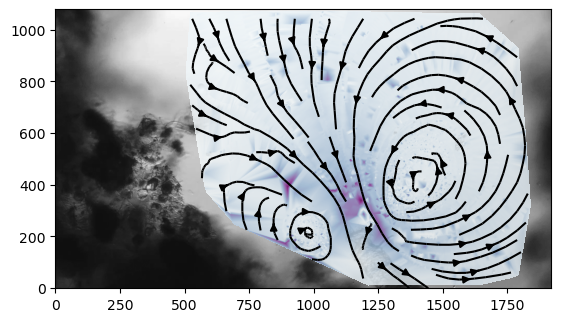

In [105]:
plt.figure()
plt.imshow(frames[frame_nr], cmap="gray", alpha=.95)
plt.imshow(speed, cmap="BuPu", alpha=.8)
plt.streamplot(grid_x, grid_y, grid_u, grid_v, color="k") # linewidth=20*speed / speed.max()
plt.gca().invert_yaxis()

### Plot valid trajectories

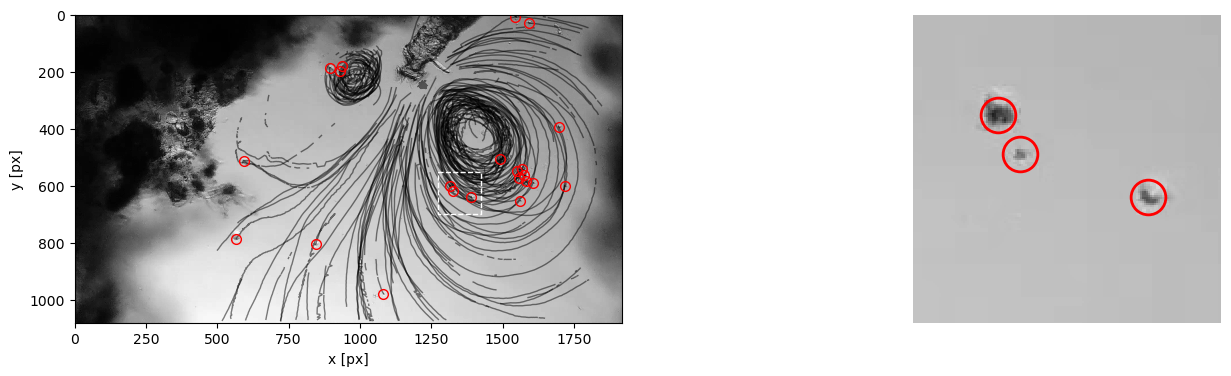

In [142]:
fig, ax = plt.subplots(1, 2, figsize=(17, 4))
tp.plot_traj(ctraj, superimpose=frames[frame_nr], ax=ax[0], plot_style={"color": "k", "lw" : 1, "alpha" : .5});
tp.annotate(ctraj[ctraj.frame == frame_nr], frames[frame_nr], ax=ax[0], plot_style={"markersize" : 7, "markeredgewidth" : 1});  # this shows the bandpass filtered image
ax[0].plot([1275, 1425, 1425, 1275, 1275], [550, 550, 700, 700, 550], "--w", lw=1)
ax[0].set_xlim(0, img_width)

#bbox = [1275, 1425, 550, 700]
tp.annotate(ctraj[ctraj.frame == frame_nr], frames[frame_nr], ax=ax[1], plot_style={"markersize" : 25, "markeredgewidth" : 2});  # this shows the bandpass filtered image
ax[1].set_xlim(1275, 1425); ax[1].set_ylim(550, 700); ax[1].invert_yaxis()
ax[1].axis("off")

#fig.savefig("./data/results/vortex/2024_0325_161529_030-tpoint2-trajectories-annotated.jpg", dpi=600)

## Plot selected particles with time color code

- load Max/Min Z projection of all Frames

In [15]:
zproj_min = np.load("./data/results/vortex/trajectories_zmin-proj-tpoint2.npy")
# zproj_norm = (zproj_min) / (zproj_min.min() * -1)
# print(zproj_norm.min(), zproj_norm.max())
# fig, ax = plt.subplots(1,2,figsize=(17, 4))
# ax[0].imshow(zproj_norm, cmap="gray")
# ax[1].imshow(zproj_min, cmap="gray")

# for velocity > random selection of particles

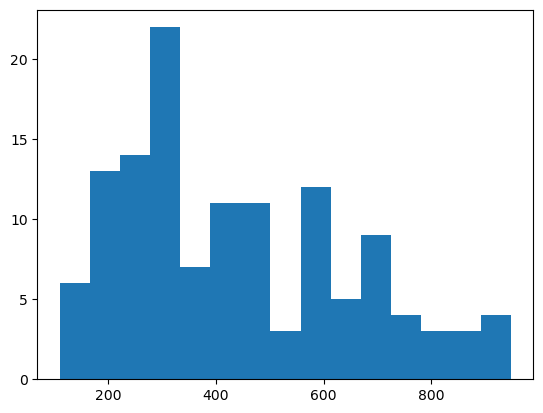

In [16]:
indices = stats.travel_dist.sort_values(ascending=False)[:10].index.values
selected_prts = sorted(stats.loc[indices, "particle"].to_numpy())
selected_prts
particles = ctraj.particle.unique()
dsize=[]
for nth, pt in enumerate(particles):  # selected_prts
    straj = ctraj.loc[ctraj["particle"] == pt]
    dsize.append(tp.diagonal_size(straj))

plt.hist(dsize, bins=15);

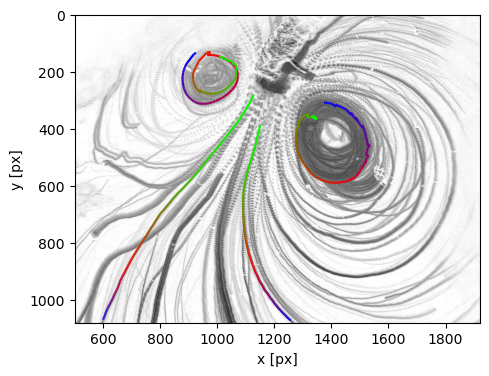

In [17]:
center_x_line = [1320, 730]
center_y_line = [0, img_height]
x_line = [700, img_width]
y_line = [0, 680]

fig, ax = plt.subplots(figsize=(17, 4))
ax.imshow(zproj_min, cmap="gray")
# ax.plot(center_x_line, center_y_line, "-k", alpha=.8, lw=.5)
# ax.plot(x_line, y_line, "-k", alpha=.8, lw=.5)
ccmap = mpl.cm.brg
prts = [288,107,490, 285] # 7,18 prts = [90, 490, 285, 445]
for nth, pt in enumerate(prts):
    traj = ctraj.loc[ctraj["particle"] == pt]
    tp.plot_traj(traj, ax=ax, colorby="frame", cmap=ccmap, label=False, plot_style={"linewidths" : 2});

ax.set_xlim(500, img_width); ax.set_ylim(0, img_height)
ax.invert_yaxis()
#fig.savefig("./data/results/vortex/2024_0325_161529_030-tpoint2-trajectories-colorby-frame.jpg", dpi=600)

### select continuous

In [18]:
is_continuous = list()
for nth, row in stats.iterrows():
    clist = row["frames_present"]
    if all(np.diff(clist)<=2): #any(np.diff(clist)>=2):
        is_continuous.append(nth)

len(is_continuous)

55

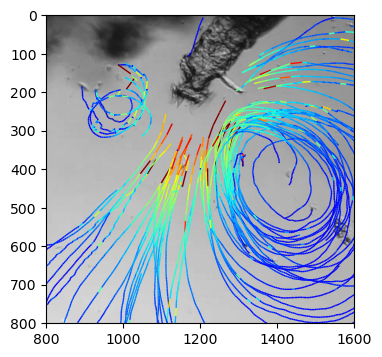

In [19]:
minmax = []
cmap = plt.cm.jet
fig, ax = plt.subplots(figsize=(17,4))
ax.imshow(frames[frame_nr], cmap="gray")
# or only continuous traj, w/o frame jump, or of different diag-size
for nth in is_continuous:  #list(set(ctraj.particle)):
    traj = ctraj.loc[ctraj["particle"] == nth]
    if not traj.empty:
        x = traj.x.to_numpy()
        y = traj.y.to_numpy()

        dx = traj.x.diff()
        dy = traj.y.diff()
        dist = np.sqrt(dx ** 2 + dy ** 2)

        vector = dist.to_numpy()[1:]
        minmax.append([vector.min(), vector.max()])
        norm = plt.Normalize(0, 35)

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=cmap, norm=norm, linewidths=1, alpha=1)
        lc.set_array(vector)
        ax.add_collection(lc)
        ax.autoscale()

ax.set_xlim(800,1600); ax.set_ylim(0,800)
ax.invert_yaxis()
#fig.savefig("./data/results/vortex/2024_0325_161529_030-tpoint2-trajectories-colorby-displacement.jpg", dpi=600)

In [72]:
minmax_ = np.array(minmax)
minmax_.shape
print(minmax_.min(), minmax_.max())

0.0 49.76037837913056


### Position change
- loop through the points to color frames by velocity or global frame nr


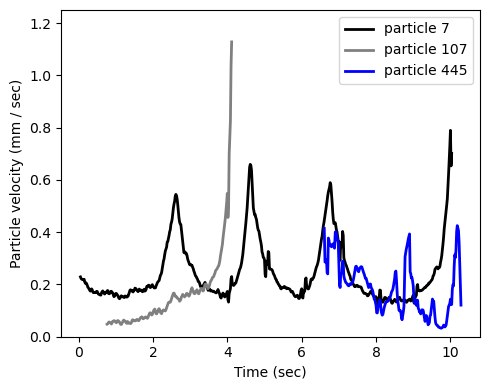

In [146]:
prts = [7,18,90,445,288,107,490, 285] # 7,18 prts = [90, 490, 285, 445]
# fig, ax = plt.subplots(len(prts), 1, figsize=(17,20))
# for nth, pt in enumerate(prts):
#     traj = ctraj.loc[ctraj["particle"] == pt]
#     xm = traj.x.diff().rolling(window=5).mean()
#     ym = traj.y.diff().rolling(window=5).mean()
#     dist = np.sqrt(xm ** 2 + ym ** 2)
#     tx = traj.frame.rolling(window=5).mean()

#     ax[nth].plot(tx, dist, "-b", label=f"particle {str(pt)}")
#     ax[nth].set_title(str(pt))
    
prts = [7, 107, 445]
prt_colors = ["k", "grey", "b"]
fig, ax = plt.subplots(figsize=(5,4))

for nth, pt in enumerate(prts):
    traj = ctraj.loc[ctraj["particle"] == pt]
    xm = traj.x.diff().rolling(window=5).mean()
    ym = traj.y.diff().rolling(window=5).mean()
    dist = (np.sqrt(xm ** 2 + ym ** 2) * .61) * 60 
    tx = traj.frame.rolling(window=5).mean()
    tx = (tx - 1800) / 60
    ax.plot(tx, dist / 1000, "-", lw=2, color=prt_colors[nth], label=f"particle {str(pt)}")

ax.set_xlabel("Time (sec)"); ax.set_ylabel("Particle velocity (mm / sec)")
ax.set_ylim(0, 1.25)
ax.legend()
plt.tight_layout()
fig.savefig("./data/results/vortex/2024_0325_161529_030-tpoint2-trajectories-displacement-timeseries.jpg", dpi=600)

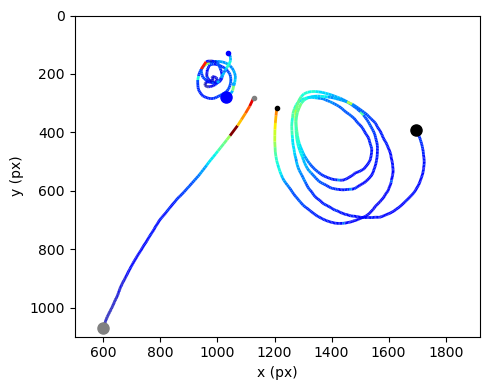

In [145]:
cmap = plt.cm.jet
fig, ax = plt.subplots(figsize=(5,4))
for nth, pt in enumerate(prts):
    traj = ctraj.loc[ctraj["particle"] == pt]
    if not traj.empty:
        x = traj.x.to_numpy()
        y = traj.y.to_numpy()

        dx = traj.x.diff()
        dy = traj.y.diff()
        dist = np.sqrt(dx ** 2 + dy ** 2)

        vector = dist.to_numpy()[1:]
        minmax.append([vector.min(), vector.max()])
        norm = plt.Normalize(0, 35)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=cmap, norm=norm, linewidths=2, alpha=1)
        lc.set_array(vector)
        ax.add_collection(lc)
        ax.autoscale()
        
        ax.plot(x[0], y[0], "o", ms=8, mec=prt_colors[nth], mfc=prt_colors[nth], label=f"particle {str(pt)}")
        ax.plot(x[-1], y[-1], "o", ms=3, mec=prt_colors[nth], mfc=prt_colors[nth])
        

ax.set_xlim(500, img_width); ax.set_ylim(0,img_height + 20)
ax.set_xlabel("x (px)"); ax.set_ylabel("y (px)")
ax.invert_yaxis()
plt.tight_layout()

fig.savefig("./data/results/vortex/2024_0325_161529_030-tpoint2-trajectories-colorby-displacement-selected-only.jpg", dpi=600)

### trajectory params

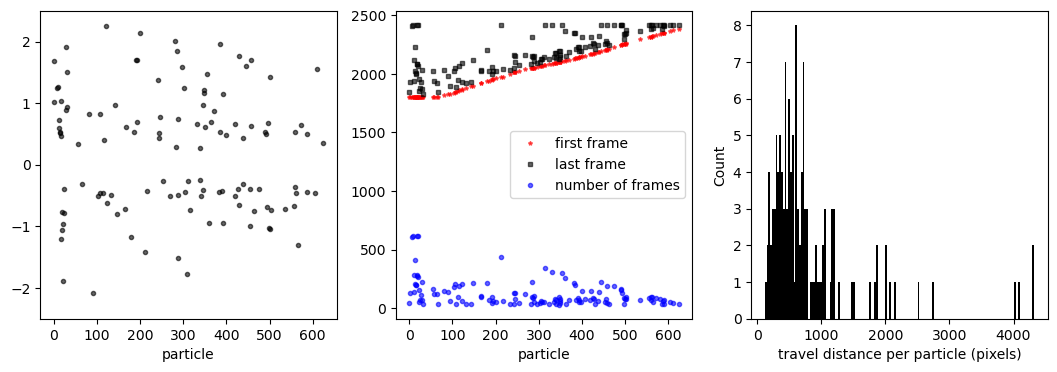

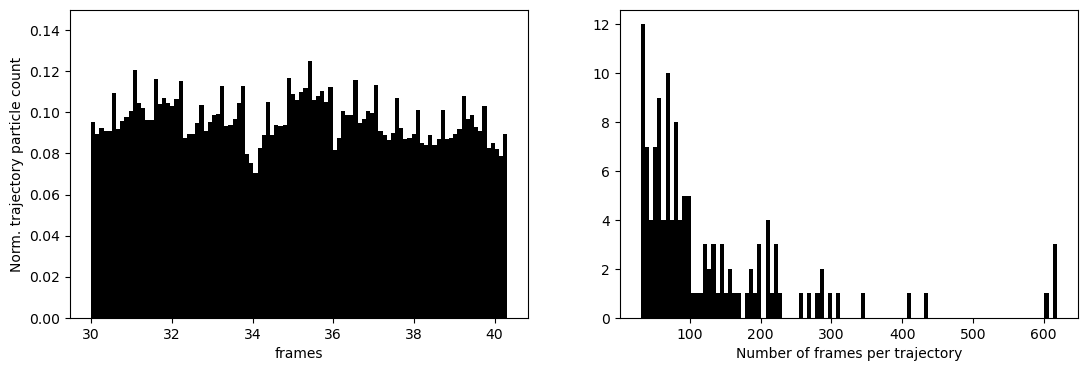

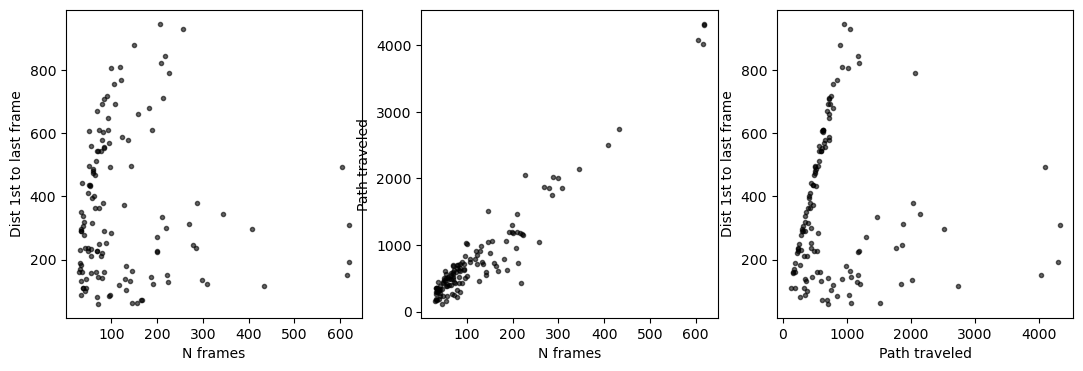

In [161]:
fig, ax = plt.subplots(1, 3, figsize=(13,4))
ax[0].plot(stats.particle, stats.ep_median, ".k", alpha=.6)
ax[0].set_ylim(-2.5, 2.5); ax[0].set_xlabel("particle");

ax[1].plot(stats.particle, stats.first_frame, "*r", ms=3, alpha=.6, label="first frame")
ax[1].plot(stats.particle, stats.last_frame, "sk", ms=3, alpha=.6, label="last frame")
ax[1].plot(stats.particle, stats.nframes, "ob", ms=3, alpha=.6, label="number of frames")
ax[1].set_xlabel("particle");
ax[1].legend()

ax[2].hist(stats.travel_dist, bins=150, color="k");
ax[2].set_xlabel("travel distance per particle (pixels)");
ax[2].set_ylabel("Count"); #ax[2].set_xlim(0, 1500);


fig, ax = plt.subplots(1, 2, figsize=(13,4))
ax[0].hist(frames_present / 60, bins=100, density=True, color="k");
ax[0].set_xlabel("frames"); ax[0].set_ylabel("Norm. trajectory particle count");
ax[0].set_ylim(0, .15); #ax[0].set_xlim(0, 1050);


ax[1].hist(stats.nframes, bins=100, color="k");
ax[1].set_xlabel("Number of frames per trajectory")
#ax[1].set_xlim(0, 300);

fig, ax = plt.subplots(1, 3, figsize=(13,4))
ax[0].plot(stats.nframes, stats.displacement_first_last, "ko", ms=3, alpha=.6)
ax[0].set_xlabel("N frames"); ax[0].set_ylabel("Dist 1st to last frame")

ax[1].plot(stats.nframes, stats.travel_dist, "ko", ms=3, alpha=.6)
ax[1].set_xlabel("N frames"); ax[1].set_ylabel("Path traveled")

ax[2].plot(stats.travel_dist, stats.displacement_first_last, "ko", ms=3, alpha=.6)
ax[2].set_xlabel("Path traveled"); ax[2].set_ylabel("Dist 1st to last frame");

## Inspect all trajectories

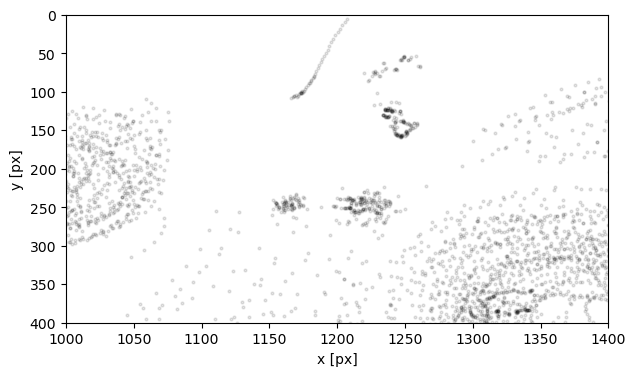

In [162]:
fig, ax = plt.subplots(figsize=(7, 4))
tp.scatter(ctraj, ax=ax, plot_style={"ms" : 2, "alpha" : .1, "color" : "k"})
ax.set_xlim(1000, 1400); ax.set_ylim(0, 400)
ax.invert_yaxis()

## Trajectory selection

In [ ]:
# # RIGHT
# cxlim = [1300, 1800]
# cylim = [300, 1000]
# bool_idx_r = (stats.x_avg > cxlim[0]) & (stats.y_avg > cylim[0]) & (stats.nframes > 40) & (stats.nframes < 180)
# print(sum(bool_idx_r))
# stats.loc[bool_idx_r, :]
# selected_particle_trajs_r = sorted([28,90,243,244,400,490])
# bool_idx2_r = stats.particle.isin(selected_particle_trajs_r)
# right_selected = [90, 490] # 400, 
# #stats.loc[bool_idx2, :]
# yxlim = frames[0].shape
# ccmap = mpl.cm.brg

# prts = stats.loc[bool_idx2_r, "particle"]
# colors = [ccmap(i)[:3] for i in np.linspace(0, 1, len(prts))]

# fig, ax = plt.subplots(len(prts), 1, figsize=(7,50))
# for nth, pt in enumerate(prts):
#     traj = ctraj.loc[ctraj["particle"] == pt]
#     tp.plot_traj(traj, ax=ax[nth], colorby="frame", cmap=ccmap, label=False);
#     #ax[nth].set_xlim(cxlim); ax[nth].set_ylim(cylim)
#     ax[nth].set_title(str(pt))
#     ax[nth].invert_yaxis()



In [164]:
# cxlim = [800, 1100]
# cylim = [0, 400]
# bool_idx = (stats.x_avg < cxlim[1]) & (stats.y_avg < cylim[1]) #& (stats.nframes > 40) & (stats.nframes < 80)
# print(sum(bool_idx))
# #stats.loc[bool_idx, :]
# selected_particle_trajs = sorted([445,386,354,285,191])
# bool_idx2 = stats.particle.isin(selected_particle_trajs)
# stats.loc[bool_idx2, :]

In [ ]:
# yxlim = frames[0].shape
# ccmap = mpl.cm.brg

# prts = stats.loc[bool_idx2, "particle"]
# left_selected = [285, 445]
# colors = [ccmap(i)[:3] for i in np.linspace(0, 1, len(prts))]

# fig, ax = plt.subplots(len(prts), 1, figsize=(7,20))
# for nth, pt in enumerate(prts):
#     traj = ctraj.loc[ctraj["particle"] == pt]
#     tp.plot_traj(traj, ax=ax[nth], colorby="frame", cmap=ccmap, label=False);
#     ax[nth].set_xlim(cxlim); ax[nth].set_ylim(cylim)
#     ax[nth].set_title(str(pt))
#     ax[nth].invert_yaxis()

## Single trajectory and Max/Min Z projection of Frames

In [62]:
indices = stats.travel_dist.sort_values(ascending=False)[:10].index.values
selected_prts = sorted(stats.loc[indices, "particle"].to_numpy())
selected_prts

[7, 9, 13, 17, 18, 21, 27, 212, 284, 315]

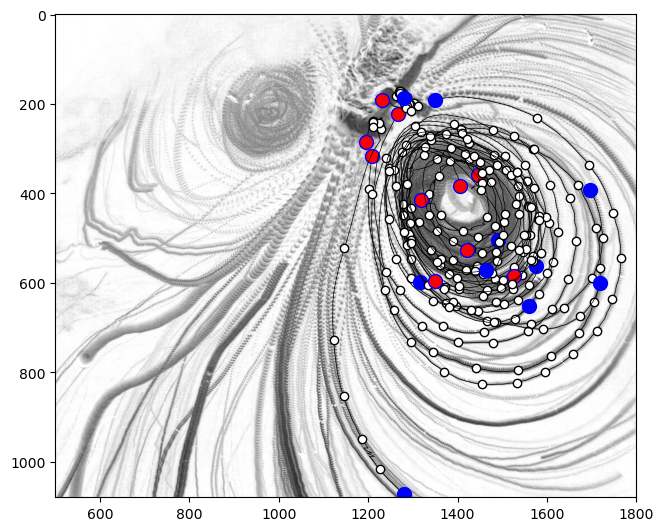

In [63]:
fig, ax = plt.subplots(figsize=(7.5,7.5))
ax.imshow(zproj_min, cmap="gray")

for prt in selected_prts:
    traj = ctraj.loc[ctraj["particle"] == prt] # 7,16
    prt_frames = traj["frame"].unique()
    x = traj.x.to_numpy()
    y = traj.y.to_numpy()
    
    ax.plot(x, y, "-k", lw=.5)
    ax.plot(x[::20], y[::20], "ok", mfc="w")
    ax.plot(x[0], y[0], "ob", mfc = "b", label="start", ms=10)
    ax.plot(x[-1], y[-1], "ob", mfc = "r", label="end", ms=10)
ax.set_xlim(500, 1800);

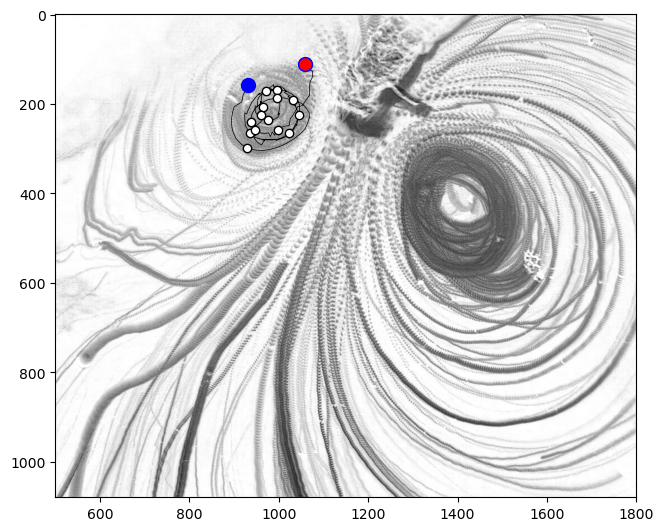

In [84]:
# have to do this with arrows, < and > do not cover it
traj = ctraj.loc[ctraj["particle"] == 354] # 7,16,9
prt_frames = traj["frame"].unique()
x = traj.x.to_numpy()
y = traj.y.to_numpy()

fig, ax = plt.subplots(figsize=(7.5,7.5))
ax.imshow(zproj_min, cmap="gray")
ax.plot(x, y, "-k", lw=.5)
ax.plot(x[::20], y[::20], "ok", mfc="w")
ax.plot(x[0], y[0], "ob", mfc = "b", label="start", ms=10)
ax.plot(x[-1], y[-1], "ob", mfc = "r", label="end", ms=10)
ax.set_xlim(500, 1800); #ax.set_ylim(0, 700)

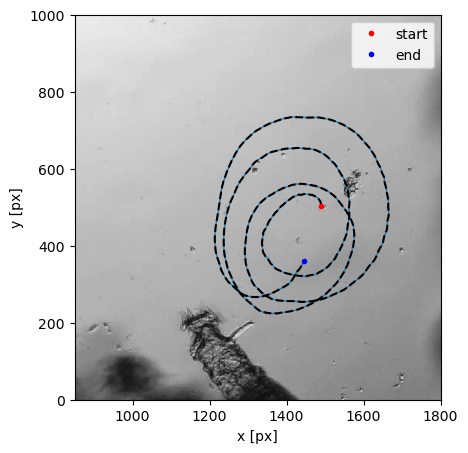

In [70]:
fig, ax = plt.subplots(figsize=(10,5))
tp.plot_traj(traj, superimpose=frames[frame_nr], ax=ax)
ax.plot(x, y, "--k")
ax.plot(x[0], y[0], ".r", label="start")
ax.plot(x[len(traj)-1], y[len(traj)-1], ".b", label="end")
ax.set_xlim(850, 1800); ax.set_ylim(0, 1000)
ax.legend()

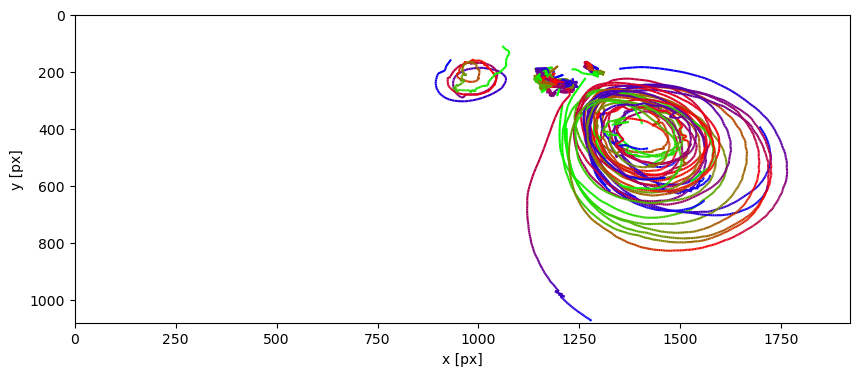

In [88]:
indices = stats.travel_dist.sort_values(ascending=False)[:20].index.values
selected_prts = sorted(stats.loc[indices, "particle"].to_numpy())

ccmap = mpl.cm.brg
yxlim = frames[0].shape
part_idx = selected_prts
colors = [ccmap(i)[:3] for i in np.linspace(0, 1, len(part_idx))]

fig, ax = plt.subplots(figsize=(10,4))
for nth, pt in enumerate(part_idx):
    traj = ctraj.loc[ctraj["particle"] == pt]
    if not traj.empty:
        #tp.plot_traj(traj, ax=ax, plot_style={"color": colors[nth]}, label=True);  # display {"linecolor": "k"}
        tp.plot_traj(traj, ax=ax, colorby="frame", cmap=ccmap, label=False);
ax.set_xlim(0, yxlim[1]); ax.set_ylim(0, yxlim[0])
ax.invert_yaxis()

/Users/mikehemberger/opt/miniconda3/lib/python3.9/site-packages/trackpy/plots.py:356: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  coords = unstacked.fillna(method='backfill').stack().loc[first_frame]


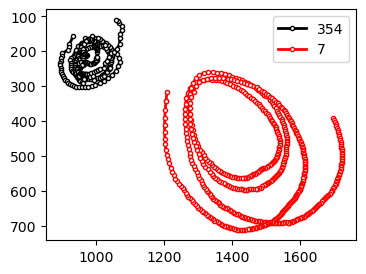

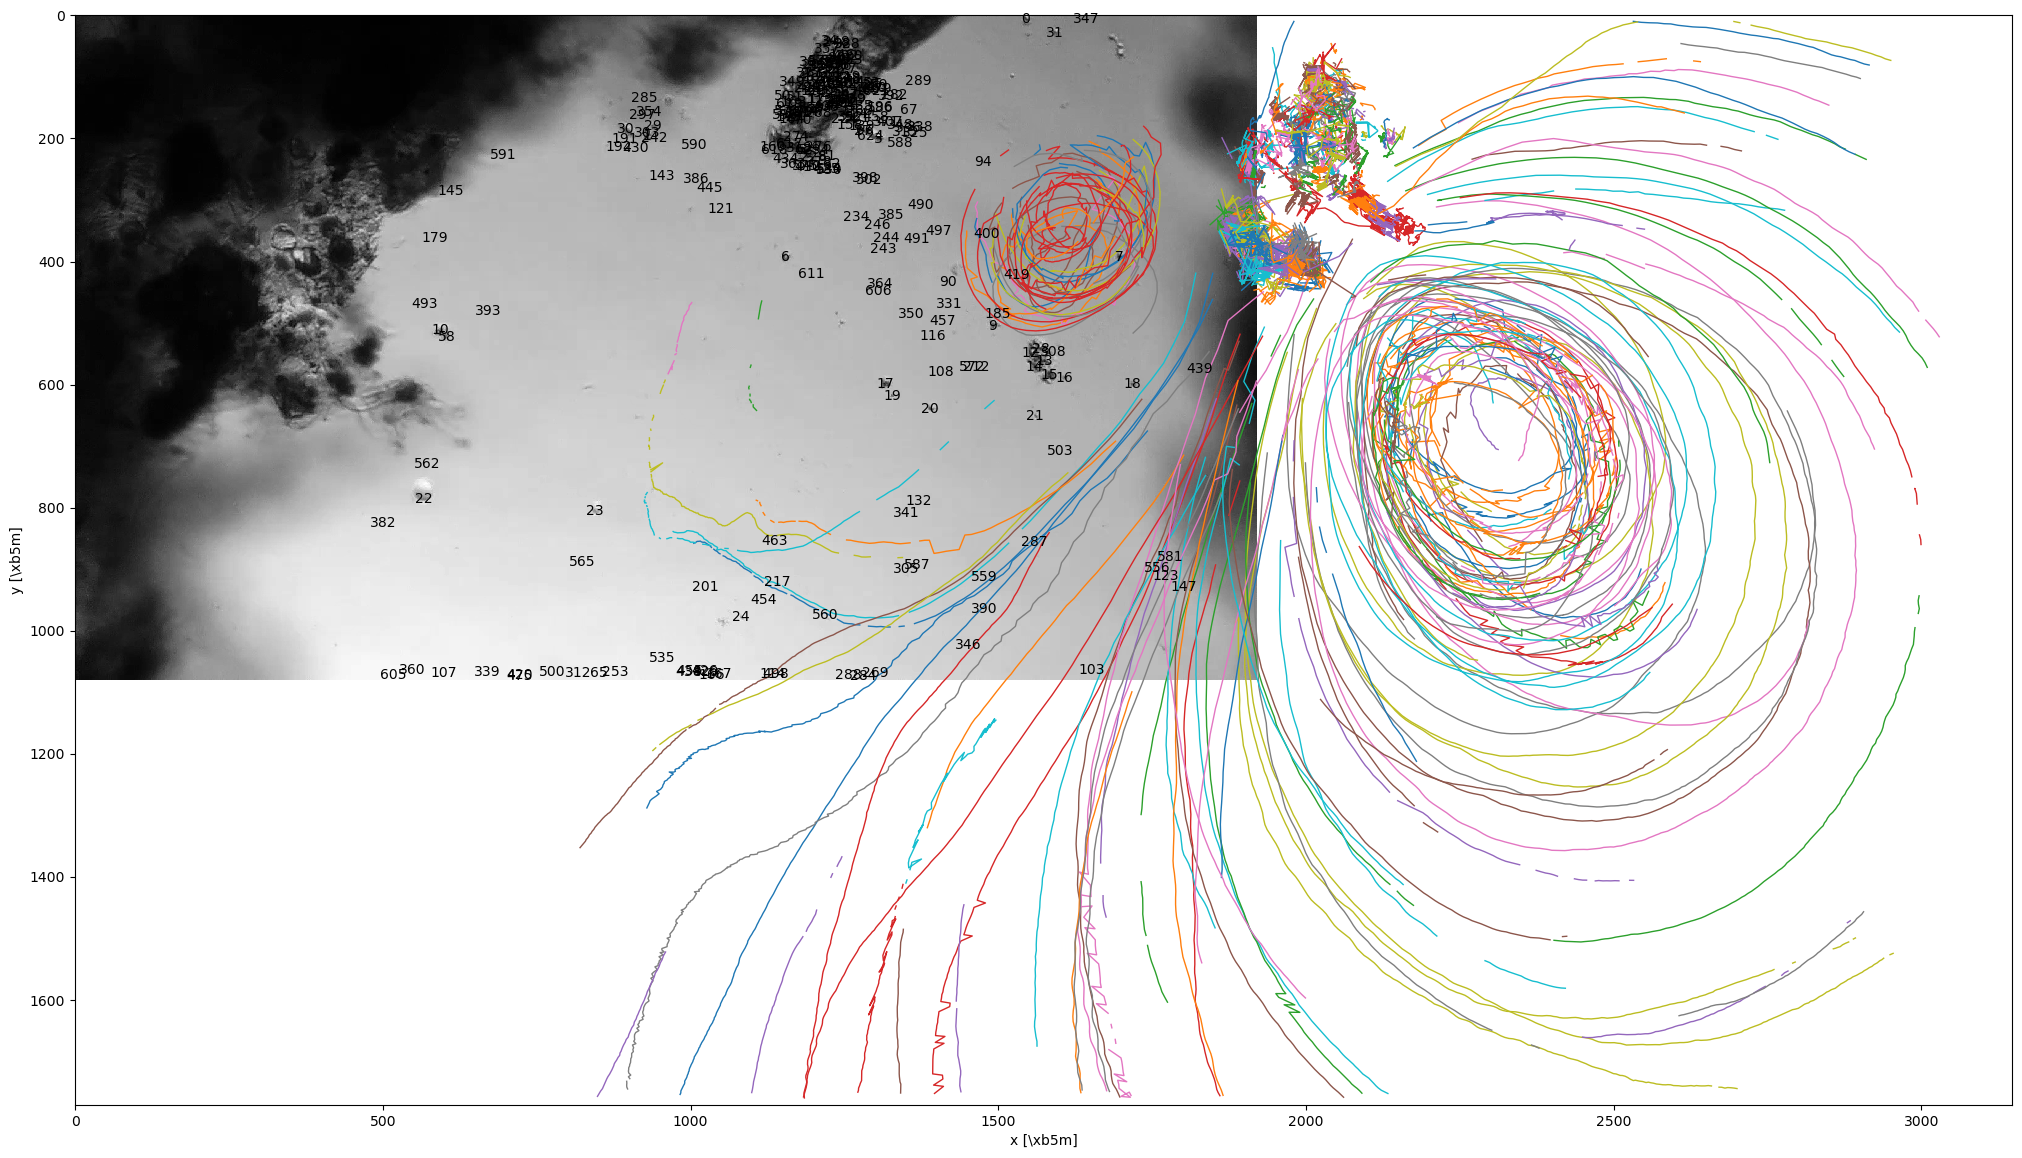

In [87]:
xy = ctraj.loc[ctraj["particle"] == 354, ["x", "y"]]
xy2 = ctraj.loc[ctraj["particle"] == 7, ["x", "y"]]

plt.figure(figsize=(4,3))
plt.plot(xy["x"], xy["y"], "-ok", lw=2, mfc="w", ms=3, label="354")
plt.plot(xy2["x"], xy2["y"], "-or", lw=2, mfc="w", ms=3, label="7")
plt.legend()
plt.gca().invert_yaxis()

plt.figure(figsize=(25,25))
tp.plot_traj(ctraj, superimpose=frames[frame_nr], label=True); # , label=True, colorby="frame", plot_style={"set_xlim" : [1400, 1550]}

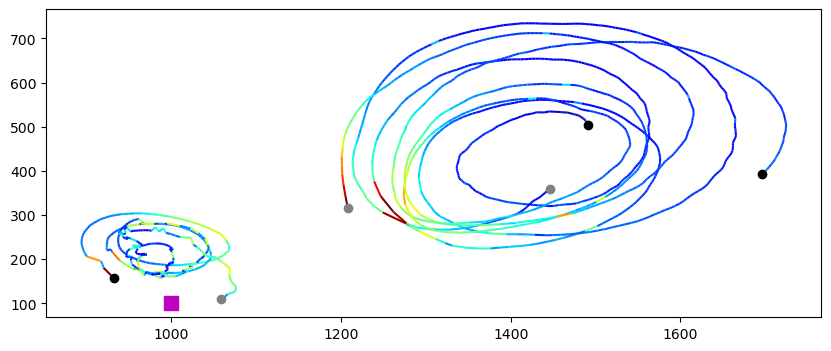

In [78]:

cmap = plt.cm.jet
part_idx = [9,7,354] # sorted([24,861, 646, 899, 207, 13,38,702, 578, 738, 912])
fig, ax = plt.subplots(figsize=(10,4))
#ax.set_facecolor('black')

for nth, pt in enumerate(part_idx):  # 13, 646, 912
    traj = ctraj.loc[ctraj["particle"] == pt]
    
    if not traj.empty:
        x, y = traj.x.to_numpy(), traj.y.to_numpy()
        dx, dy = traj.x.diff(), traj.y.diff()
        
        dist = np.sqrt(dx ** 2 + dy ** 2)
        vector = dist.to_numpy()[1:]
        norm = plt.Normalize(vector.min(), vector.max())
        
        # Create a LineCollection from the data
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=cmap, norm=norm)
        lc.set_array(vector)
        ax.add_collection(lc)
        ax.autoscale()
        
        ax.plot(x[0], y[0], "ok", mfc="k", label="start")
        ax.plot(x[len(traj)-1], y[len(traj)-1], "o", mec="gray", mfc="gray", label="end")

ax.plot(1000, 100, "sm", mfc="m", ms=10, label="corona")


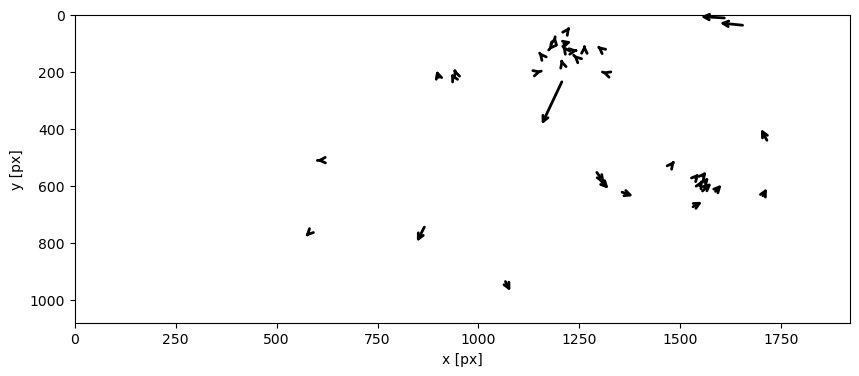

In [83]:
fig, ax = plt.subplots(figsize=(10,4))
tp.plot_displacements(ctraj, 1800, 1810, ax=ax);
ax.set_xlim(0, yxlim[1]); ax.set_ylim(0, yxlim[0])
ax.invert_yaxis()

In [ ]:
# VELOCITY FIELD FOR LATER 
# i = 0
# d = data[data.frame==i]
# plt.imshow(rawframes[i])
# plt.quiver(d.x, d.y, d.dx, -d.dy, pivot='middle', headwidth=4, headlength=6, color='red')
# plt.axis('off')